In [1]:
#!pip install gymnasium
#!pip install swig
#!pip install gymnasium[box2d]
from IPython import display
%matplotlib inline
import gymnasium as gym
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import time
import random
#torch.set_default_device('cuda')

In [2]:
from PIL import Image
import numpy as np
def display_image(imageArray):
    display.display(Image.fromarray(np.array(imageArray),'RGB'),clear=True)

In [3]:
from collections import namedtuple
Transition  = namedtuple('Transition', ('state','action', 'state_next','reward'))

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_STEP = 500
NUM_EPISODE = 500
CAPACITY = 10000
BATCH_SIZE = 32
GAMMA = 0.99
memory = []
index = 0

model = nn.Sequential()
model.add_module('fc1',nn.Linear(4,32))
model.add_module('relu1',nn.ReLU())
model.add_module('fc2', nn.Linear(32,32))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(32,2))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

def push(state, action, state_next, reward):
    global index
    #print(index)
    if len(memory) < CAPACITY:
        memory.append(None)
    memory[index] = Transition(state,action,state_next, reward)
    index = (index + 1) % CAPACITY

def sample(batch_size):
    return random.sample(memory,batch_size)

def replay():
    if len(memory) < BATCH_SIZE:
        return
    transition = sample(BATCH_SIZE)
    batch = Transition(*zip(*transition))
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)
    non_final_next_states = torch.cat([s for s in batch.state_next if s is not None]).to(device)
    model.eval()
    state_action_value = model(state_batch).gather(1,action_batch)
    mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.state_next))).to(device) != 0
    nsv = torch.zeros(BATCH_SIZE).to(device)
    nsv[mask] = model(non_final_next_states).max(1)[0].detach().to(device)
    expected_state_action_values = reward_batch + GAMMA * nsv
    model.train()
    loss = F.smooth_l1_loss(state_action_value, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
def reset(env):
      observation = env.reset()[0]
      return observation

def reset_memory():
    global memory
    global index
    memory = []
    index = 0

def get_action(s,epsilon):
    if np.random.rand() < epsilon:
        action = torch.LongTensor([[random.randrange(2)]]).to(device)
    else:
        model.eval()
        with torch.no_grad():
            action = model(s).max(1)[1].view(1,1)
    return action

# def Q_learning(s, a, r, s_next, Q, eta, gamma, is_terminated):
#     s = digitize_state(s)
#     s_next = digitize_state(s_next)
#     if is_terminated:
#         Q[s, a] = Q[s, a] + eta * (r- Q[s, a])
#     else:
#         Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])
#     return Q

def run_once(env, initial_observation, epsilon, show=False, train=True):
    observation = initial_observation
    s = torch.from_numpy(observation).type(torch.FloatTensor)
    s = torch.unsqueeze(s,0).to(device)
    a = get_action(s, epsilon)
    a_next = a
    count = 0;
    while True:
        is_terminated = False
        if show:
            time.sleep(0.01)
            img = env.render()
            display_image(img)
        a = a_next
        #s_a_history[-1][1] = a
        s_next, reward, terminated, truncated, info = env.step(a.item())
        s_next = torch.from_numpy(s_next).type(torch.FloatTensor)
        s_next = torch.unsqueeze(s_next,0).to(device)
        #s_a_history.append([s_next, np.nan])
        if count > 500:
            r = torch.FloatTensor([1.0])
            a_next = None
            is_terminated = True
            s_next = None
        elif count < 500 and terminated:
            r = torch.FloatTensor([-1.0])
            a_next = None
            is_terminated = True
            s_next = None
        else:
            r = torch.FloatTensor([0.0])
            a_next = get_action(s_next, epsilon)
        push(s, a, s_next, r)
        if train:
            replay()
        if is_terminated:
            if show:
                time.sleep(0.01)
                img = env.render()
                display_image(img)
            break
        else:
            s = s_next
        count += 1
        

In [28]:
# model = nn.Sequential()
# model.add_module('fc1',nn.Linear(4,32))
# model.add_module('relu1',nn.ReLU())
# model.add_module('fc2', nn.Linear(32,32))
# model.add_module('relu2', nn.ReLU())
# model.add_module('fc2', nn.Linear(32,2))

a = []
memory=[]
memory.append(Transition(torch.Tensor([1,2,3,4]).unsqueeze(0),torch.Tensor([0]).unsqueeze(0),torch.Tensor([3,4,2,2]).unsqueeze(0),torch.Tensor([1]).unsqueeze(0)))
memory.append(Transition(torch.Tensor([5,5,7,6]).unsqueeze(0),torch.Tensor([1]).unsqueeze(0),torch.Tensor([7,0,2,0]).unsqueeze(0),torch.Tensor([0]).unsqueeze(0)))
memory.append(Transition(torch.Tensor([6,2,3,4]).unsqueeze(0),torch.Tensor([1]).unsqueeze(0),None,torch.Tensor([0]).unsqueeze(0)))
#memory.append(Transition([6,2,3,4],[1],[3,5,4,2],0))
batch = Transition(*zip(*memory))



state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)
non_final_next_states = torch.cat([s for s in batch.state_next if s is not None])
state_batch
model.eval()
model(state_batch).gather(1,action_batch.long())
mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.state_next))) != 0
nsv = torch.zeros(3)
nsv[mask] = model(non_final_next_states).max(1)[0].detach()

#model(state_batch[0].unsqueeze(1)).max(1)[1].view(1,1)
get_action(state_batch[0].unsqueeze(0),0).item()
#batch
#torch.cat(batch.reward)

0

In [8]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
epsilon = 0.5
is_continue = True
episode = 1
reset_memory()
while is_continue:
    observation = reset(env)
    print('episode: ' + str(episode))
    epsilon = epsilon / 1.1
    run_once(env, observation, epsilon, show=False)
    episode = episode + 1
    if episode > 1000:
        break
env.close()

episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
episode: 51
episode: 52
episode: 53
episode: 54
episode: 55
episode: 56
episode: 57
episode: 58


KeyboardInterrupt: 

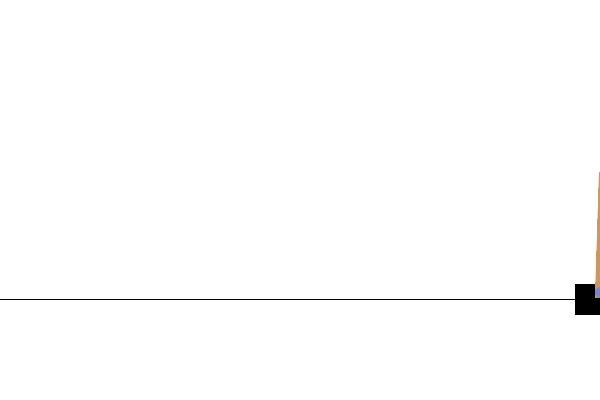

In [9]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env.reset()
reset_memory()
observation = reset(env)
run_once(env, observation, 0, show=True, train=False)
# ss = torch.from_numpy(observation).type(torch.FloatTensor)
# ss = torch.unsqueeze(ss,0)
# ss

device(type='cuda', index=0)